In [12]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [13]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
from transformers import TFXLNetForSequenceClassification, XLNetTokenizer

## Data

In [16]:
test_dataset = pd.read_table("test_dataset.csv",  index_col=0)
test_dataset = test_dataset[:8000]
test_dataset

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,bias_magnitude,bias_text,content,pred_labels
0,2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0,0.0,center,david cole is a professor of constitutional la...,1
1,4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0,0.0,center,u.s. immigration citizenship and immigration s...,2
2,8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,the following irresponsible police...,498,0.5,-0.5,Liberal,1,1,1.0,left,the following irresponsible police...,2
3,9,http://www.nytimes.com/2013/05/24/us/politics/...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,an alternative possibility is that a bipartisa...,372,0.0,0.0,Neutral,0,0,0.0,center,an alternative possibility is that a bipartisa...,1
4,11,http://www.latimes.com/news/local/la-me-cap-gu...,other,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive,"sacramento — “living in parallel universes,” i...",600,0.0,0.5,Somewhat Conservative,1,-1,0.5,right,"sacramento — “living in parallel universes,” i...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,11942,http://www.dailykos.com/story/2013/01/16/11794...,Opinion,0,Republican Scandals,None,Neutral,Negative,what's michele thinking? who knows? the juic...,345,0.0,-1.0,Liberal,1,1,1.0,left,what's michele thinking? who knows? the juic...,1
7996,11943,http://politicalticker.blogs.cnn.com/2013/11/0...,News,0,Republican Scandals,None,Neutral,SomewhatNegative,7 years ago ( SOURCE ) - u.s. sen. ted cruz i...,358,0.0,-0.5,Somewhat Liberal,1,1,0.5,left,7 years ago ( SOURCE ) - u.s. sen. ted cruz i...,1
7997,11945,http://www.usatoday.com/story/onpolitics/2013/...,News,1,Republican Scandals,None,Neutral,Neutral,catalina camia and alan gomez SOURCE rep. ...,327,0.0,0.0,Neutral,0,0,0.0,center,catalina camia and alan gomez SOURCE rep. ...,1
7998,11946,http://www.dailykos.com/story/2013/11/06/12535...,Opinion,1,Republican Scandals,None,Neutral,Negative,in an interview with national review online on...,600,0.0,-1.0,Liberal,1,1,1.0,left,in an interview with national review online on...,1


In [17]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# tokenizer_transformer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
test_labels = np.asarray(le.fit_transform(test_dataset['bias_text']))

test_dataset["real_labels"] =test_labels
test_dataset

,index,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote,article,length,democrat.bias,republican.bias,biaslabel,isbiased,biascategories,bias_magnitude,bias_text,content,pred_labels,real_labels
0,2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,david cole is a professor of constitutional la...,600,0.0,0.0,Neutral,0,0,0.0,center,david cole is a professor of constitutional la...,1,0
1,4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral,u.s. immigration citizenship and immigration s...,600,0.0,0.0,Neutral,0,0,0.0,center,u.s. immigration citizenship and immigration s...,2,0
2,8,http://www.dailykos.com/story/2013/12/02/12595...,News,1,Civil Rights,Civil Rights,SomewhatPositive,SomewhatNegative,the following irresponsible police...,498,0.5,-0.5,Liberal,1,1,1.0,left,the following irresponsible police...,2,1
3,9,http://www.nytimes.com/2013/05/24/us/politics/...,News,1,Civil Rights,Civil Rights,Neutral,Neutral,an alternative possibility is that a bipartisa...,372,0.0,0.0,Neutral,0,0,0.0,center,an alternative possibility is that a bipartisa...,1,0
4,11,http://www.latimes.com/news/local/la-me-cap-gu...,other,0,Civil Rights,Civil Rights,Neutral,SomewhatPositive,"sacramento — “living in parallel universes,” i...",600,0.0,0.5,Somewhat Conservative,1,-1,0.5,right,"sacramento — “living in parallel universes,” i...",1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,11942,http://www.dailykos.com/story/2013/01/16/11794...,Opinion,0,Republican Scandals,None,Neutral,Negative,what's michele thinking? who knows? the juic...,345,0.0,-1.0,Liberal,1,1,1.0,left,what's michele thinking? who knows? the juic...,1,1
7996,11943,http://politicalticker.blogs.cnn.com/2013/11/0...,News,0,Republican Scandals,None,Neutral,SomewhatNegative,7 years ago ( SOURCE ) - u.s. sen. ted cruz i...,358,0.0,-0.5,Somewhat Liberal,1,1,0.5,left,7 years ago ( SOURCE ) - u.s. sen. ted cruz i...,1,1
7997,11945,http://www.usatoday.com/story/onpolitics/2013/...,News,1,Republican Scandals,None,Neutral,Neutral,catalina camia and alan gomez SOURCE rep. ...,327,0.0,0.0,Neutral,0,0,0.0,center,catalina camia and alan gomez SOURCE rep. ...,1,0
7998,11946,http://www.dailykos.com/story/2013/11/06/12535...,Opinion,1,Republican Scandals,None,Neutral,Negative,in an interview with national review online on...,600,0.0,-1.0,Liberal,1,1,1.0,left,in an interview with national review online on...,1,1


In [ ]:
# 0 is center
# 1 is left
# 2 is right

<AxesSubplot:>

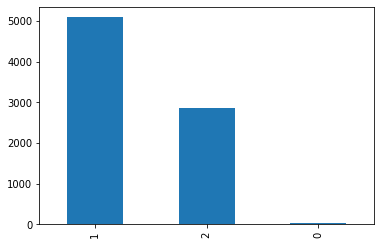

In [18]:
test_dataset["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

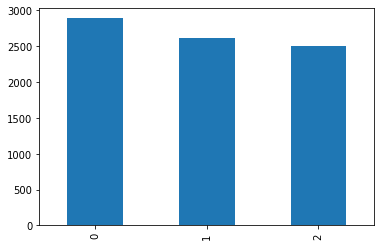

In [21]:
test_dataset["real_labels"].value_counts().plot.bar()

<AxesSubplot:>

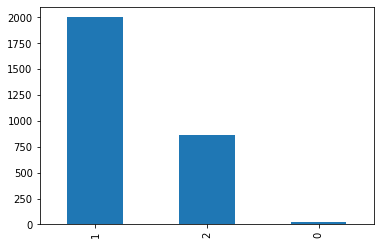

In [23]:
test_dataset[test_dataset["real_labels"]==0]["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

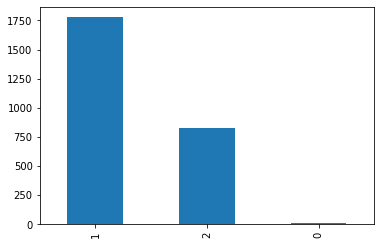

In [24]:
test_dataset[test_dataset["real_labels"]==1]["pred_labels"].value_counts().plot.bar()

<AxesSubplot:>

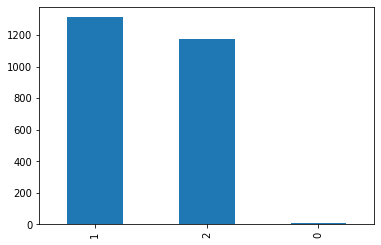

In [25]:
test_dataset[test_dataset["real_labels"]==2]["pred_labels"].value_counts().plot.bar()